In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/Tornadoes_SPC_1950to2015.csv')

In [4]:
data

,om,yr,mo,dy,date,time,tz,st,stf,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,3,3,0,6.00,0.0,38.77,-90.22,38.83,-90.03,9.50,150,0
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,17,2,3,3,0,5.00,0.0,39.10,-89.30,39.12,-89.23,3.60,130,0
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,39,1,1,1,0,4.00,0.0,40.88,-84.58,0.00,0.00,0.10,10,0
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,5,1,3,1,1,3.00,0.0,34.40,-94.37,0.00,0.00,0.60,17,0
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,29,2,2,5,0,5.00,0.0,37.60,-90.68,37.63,-90.65,2.30,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60109,607506,2015,12,28,12/28/2015,3:20:00,3,LA,22,0,1,0,0,0.00,0.0,30.08,-90.54,30.08,-90.53,0.60,150,0
60110,613277,2015,12,28,12/28/2015,4:46:00,3,AR,5,0,2,0,0,0.05,0.0,34.70,-90.92,34.78,-90.90,5.75,40,0
60111,607307,2015,12,28,12/28/2015,5:43:00,3,MS,28,0,1,0,0,0.10,0.0,31.54,-89.53,31.61,-89.49,5.59,100,0
60112,612738,2015,12,28,12/28/2015,8:30:00,3,FL,12,0,1,0,0,0.01,0.0,30.76,-87.24,30.77,-87.23,0.78,75,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60114 entries, 0 to 60113
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   om      60114 non-null  int64  
 1   yr      60114 non-null  int64  
 2   mo      60114 non-null  int64  
 3   dy      60114 non-null  int64  
 4   date    60114 non-null  object 
 5   time    60114 non-null  object 
 6   tz      60114 non-null  int64  
 7   st      60114 non-null  object 
 8   stf     60114 non-null  int64  
 9   stn     60114 non-null  int64  
 10  mag     60114 non-null  int64  
 11  inj     60114 non-null  int64  
 12  fat     60114 non-null  int64  
 13  loss    60114 non-null  float64
 14  closs   60114 non-null  float64
 15  slat    60114 non-null  float64
 16  slon    60114 non-null  float64
 17  elat    60114 non-null  float64
 18  elon    60114 non-null  float64
 19  len     60114 non-null  float64
 20  wid     60114 non-null  int64  
 21  fc      60114 non-null  int64  
dty

In [7]:
data['mag'].unique()

array([3, 1, 2, 4, 0, 5])

In [8]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop date column (redundant)
    df = df.drop('date', axis=1)
    
    # Drop id columns
    df = df.drop(['om', 'stn'], axis=1)
    
    # Drop fc column (irrelevant)
    df = df.drop('fc', axis=1)
    
    # Extract time features
    df['time'] = pd.to_datetime(df['time'])
    df['hour'] = df['time'].apply(lambda x: x.hour)
    df['minute'] = df['time'].apply(lambda x: x.minute)
    df = df.drop('time', axis=1)
    
    # One-hot encode the nominal features
    for column in ['tz', 'st', 'stf']:
        df = onehot_encode(df, column=column)
    
    # Split df into X and y
    y = df['mag']
    print (y.unique())
   
    X = df.drop('mag', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess_inputs(data)

[3 1 2 4 0 5]


In [9]:
X_train

,yr,mo,dy,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,hour,minute,tz_0,tz_3,tz_6,tz_9,st_AK,st_AL,st_AR,st_AZ,st_CA,st_CO,st_CT,st_DC,st_DE,st_FL,st_GA,st_HI,st_IA,st_ID,st_IL,st_IN,st_KS,st_KY,st_LA,st_MA,st_MD,st_ME,st_MI,st_MN,st_MO,st_MS,st_MT,st_NC,st_ND,st_NE,st_NH,st_NJ,st_NM,st_NV,st_NY,st_OH,st_OK,st_OR,st_PA,st_PR,st_RI,st_SC,st_SD,st_TN,st_TX,st_UT,st_VA,st_VT,st_WA,st_WI,st_WV,st_WY,stf_1,stf_2,stf_4,stf_5,stf_6,stf_8,stf_9,stf_10,stf_11,stf_12,stf_13,stf_15,stf_16,stf_17,stf_18,stf_19,stf_20,stf_21,stf_22,stf_23,stf_24,stf_25,stf_26,stf_27,stf_28,stf_29,stf_30,stf_31,stf_32,stf_33,stf_34,stf_35,stf_36,stf_37,stf_38,stf_39,stf_40,stf_41,stf_42,stf_44,stf_45,stf_46,stf_47,stf_48,stf_49,stf_50,stf_51,stf_53,stf_54,stf_55,stf_56,stf_72
46779,0.897770,2.103604,-0.443014,-0.077047,-0.067993,-0.117031,-0.01555,-1.273971,1.081172,0.511311,-0.682013,-0.387409,-0.247680,-0.847778,0.825620,-0.011942,0.025339,-0.021806,-0.004875,-0.006894,-0.186881,-0.172797,-0.061781,-0.085588,-0.187085,-0.039635,0.0,-0.033794,4.220244,-0.158562,-0.026711,-0.205311,-0.056733,-0.202212,-0.152552,-0.265457,-0.124078,-0.178901,-0.050491,-0.073972,-0.046297,-0.128449,-0.171112,-0.19153,-0.186745,-0.079609,-0.146319,-0.159896,-0.220557,-0.038722,-0.047819,-0.098949,-0.034835,-0.084311,-0.129686,-0.255680,-0.041973,-0.111859,-0.018243,-0.012899,-0.126814,-0.173525,-0.138858,-0.407920,-0.044724,-0.105478,-0.027587,-0.043917,-0.147417,-0.044187,-0.106737,-0.186881,-0.006894,-0.061781,-0.172797,-0.085588,-0.187085,-0.039635,-0.033794,0.0,4.220244,-0.158562,-0.026711,-0.056521,-0.202212,-0.152552,-0.205374,-0.265457,-0.124078,-0.178901,-0.046297,-0.073972,-0.050491,-0.128449,-0.171112,-0.186745,-0.19153,-0.079609,-0.220557,-0.034835,-0.038722,-0.047819,-0.098949,-0.084311,-0.146319,-0.159896,-0.129781,-0.255680,-0.041973,-0.111859,-0.012899,-0.126814,-0.173525,-0.138858,-0.407880,-0.044724,-0.027587,-0.105478,-0.043917,-0.044187,-0.147417,-0.106737,-0.018243
55445,1.292855,-0.405231,-0.557424,-0.077047,-0.067993,0.435713,-0.01555,0.730677,-0.181883,1.054821,-0.919738,-0.292728,1.528395,-0.031984,1.107806,-0.011942,0.025339,-0.021806,-0.004875,-0.006894,-0.186881,-0.172797,-0.061781,-0.085588,-0.187085,-0.039635,0.0,-0.033794,-0.236953,-0.158562,-0.026711,4.870654,-0.056733,-0.202212,-0.152552,-0.265457,-0.124078,-0.178901,-0.050491,-0.073972,-0.046297,-0.128449,-0.171112,-0.19153,-0.186745,-0.079609,-0.146319,-0.159896,-0.220557,-0.038722,-0.047819,-0.098949,-0.034835,-0.084311,-0.129686,-0.255680,-0.041973,-0.111859,-0.018243,-0.012899,-0.126814,-0.173525,-0.138858,-0.407920,-0.044724,-0.105478,-0.027587,-0.043917,-0.147417,-0.044187,-0.106737,-0.186881,-0.006894,-0.061781,-0.172797,-0.085588,-0.187085,-0.039635,-0.033794,0.0,-0.236953,-0.158562,-0.026711,-0.056521,-0.202212,-0.152552,4.869163,-0.265457,-0.124078,-0.178901,-0.046297,-0.073972,-0.050491,-0.128449,-0.171112,-0.186745,-0.19153,-0.079609,-0.220557,-0.034835,-0.038722,-0.047819,-0.098949,-0.084311,-0.146319,-0.159896,-0.129781,-0.255680,-0.041973,-0.111859,-0.012899,-0.126814,-0.173525,-0.138858,-0.407880,-0.044724,-0.027587,-0.105478,-0.043917,-0.044187,-0.147417,-0.106737,-0.018243
29711,0.164042,-0.823370,-1.587113,-0.077047,-0.067993,-0.117584,-0.01555,-0.513183,-0.573431,-1.111276,1.122409,-0.399245,-0.349170,0.375913,0.204813,-0.011942,0.025339,-0.021806,-0.004875,-0.006894,-0.186881,-0.172797,-0.061781,-0.085588,-0.187085,-0.039635,0.0,-0.033794,-0.236953,-0.158562,-0.026711,-0.205311,-0.056733,-0.202212,-0.152552,-0.265457,-0.124078,-0.178901,-0.050491,-0.073972,-0.046297,-0.128449,-0.171112,-0.19153,-0.186745,-0.079609,-0.146319,-0.159896,-0.220557,-0.038722,-0.047819,-0.098949,-0.034835,-0.084311,-0.129686,3.911145,-0.041973,-0.111859,-0.018243,-0.012899,-0.126814,-0.173525,-0.138858,-0.407920,-0.044724,-0.105478,-0.027587,-0.043917,-0.147417,-0.044187,-0.106737,-0.186881,-0.006894,-0.061781,-0.172797,-0.085588,-0.187085,-0.039635,-0.033794,0.0,-0.236953,-0.158562,-0.026711,-

In [10]:
y_train

46779    1
55445    1
29711    0
42871    0
58898    1
        ..
50057    0
32511    0
5192     1
12172    0
33003    0
Name: mag, Length: 42079, dtype: int64

In [11]:
print (X_train.shape, y_train.shape)

(42079, 123) (42079,)


In [12]:
input_shape=(X_train.shape[1])
input=tf.keras.Input(shape=input_shape)
x=Dense(1024, activation='relu')(input)
x=Dropout(.4)(x)
x=Dense(64, activation='relu')(x)
x=Dropout(.4)(x)
output=Dense(6, activation='softmax')(x)
model=Model(inputs=input, outputs=output)
model.compile(optimizer=Adam(.001), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 123)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              126976    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 192,966
Trainable params: 192,966
Non-trainable params: 0
________________________________________________

In [38]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=2, verbose=1,)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",  patience=5, verbose=1, restore_best_weights=True)
callbacks=[rlronp, estop]
    
history=model.fit(X_train, y_train,verbose=2,batch_size=32, epochs=50,  validation_split=0.2,  shuffle=True, class_weight=None, callbacks=callbacks)

Epoch 1/50
1052/1052 - 2s - loss: 0.7428 - accuracy: 0.6769 - val_loss: 0.7614 - val_accuracy: 0.6723
Epoch 2/50
1052/1052 - 2s - loss: 0.7388 - accuracy: 0.6801 - val_loss: 0.7617 - val_accuracy: 0.6731
Epoch 3/50

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1052/1052 - 2s - loss: 0.7389 - accuracy: 0.6773 - val_loss: 0.7614 - val_accuracy: 0.6725
Epoch 4/50
1052/1052 - 2s - loss: 0.7411 - accuracy: 0.6770 - val_loss: 0.7614 - val_accuracy: 0.6729
Epoch 5/50

Epoch 00005: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
1052/1052 - 2s - loss: 0.7351 - accuracy: 0.6808 - val_loss: 0.7614 - val_accuracy: 0.6728
Epoch 6/50
1052/1052 - 2s - loss: 0.7369 - accuracy: 0.6792 - val_loss: 0.7613 - val_accuracy: 0.6723
Epoch 7/50
1052/1052 - 2s - loss: 0.7354 - accuracy: 0.6824 - val_loss: 0.7613 - val_accuracy: 0.6715
Epoch 8/50
1052/1052 - 2s - loss: 0.7387 - accuracy: 0.6812 - val_loss: 0.7614 - val_accuracy: 0.6722
Epoch 9/50

Epoch 000

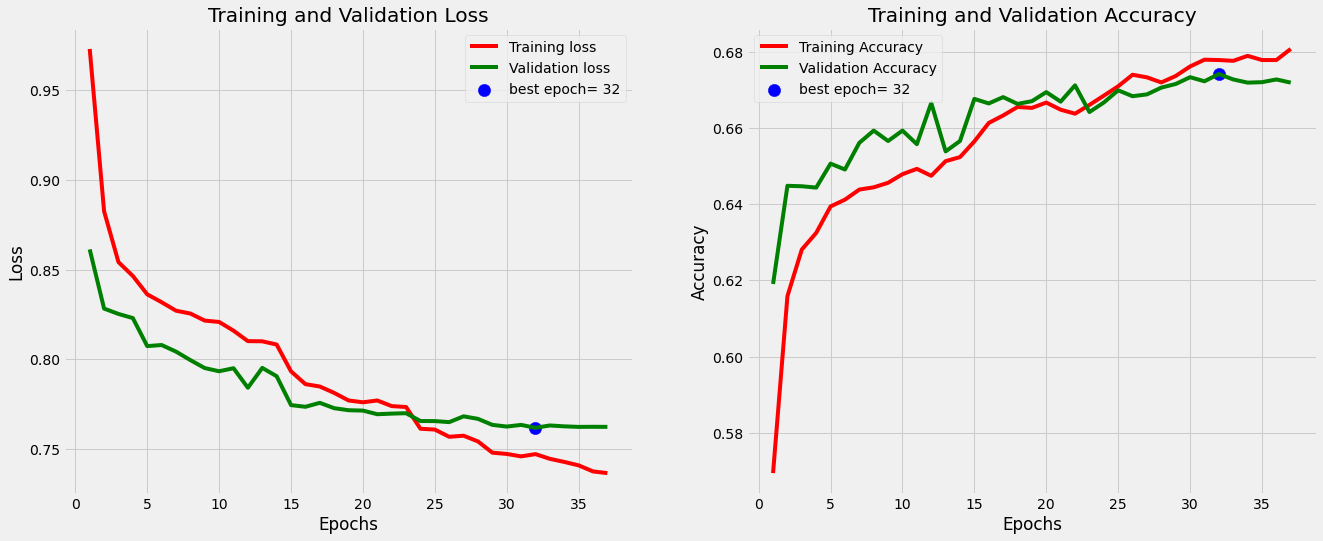

In [14]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
tr_plot(history,0)

In [37]:
accuracy=model.evaluate(X_test, y_test)[1]*100
print ('model accuracy on test set is {0:7.2f}'.format(accuracy))

564/564 [==============================] - 1s 1ms/step - loss: 0.7583 - accuracy: 0.6730
model accuracy on test set is   67.30
